In [2]:
'''*-----------------------------------------------------------------------*---
                                                         Author: Jason Ma
                                                         Date  : Jan 19 2019
                              traffic-sign-classifier

  File Name  : traffic-sign-classifier.py
  Description: Trains CNN to classify traffic signs using the GTSRB dataset.
---*-----------------------------------------------------------------------*'''

import tensorflow as tf
import cv2
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [14]:
#global vars
train_dir = 'GTSRB/train/'
test_dir  = 'GTSRB/test/'
img_shape = (32, 32)
n_classes = 43

train_imgs = []
train_labels = []

test_imgs = []
test_labels = []

#read in train data
for i in range(n_classes):
  csv_path = train_dir + str(i) + '/GT-' + "%05d" % (i) + '.csv'
  #print(csv_path)
  with open(csv_path, 'r') as f:
    line = f.readline()
    
    for line in f:
      line = line.strip().split(';')
      full_path = train_dir + str(i) + "/" + line[0]
      img = cv2.imread(full_path, 0)
      img = cv2.resize(img, img_shape)
      train_imgs.append(img)
      train_labels.append(int(line[7]))
      
      '''
      label = int(line[7])
      if label == 14:
        train_labels.append(1)
      else:
        train_labels.append(0)
      '''

#read in test data
csv_path = test_dir + 'GT-final_test.csv'

with open(csv_path, 'r') as f:
  line = f.readline()
  
  for line in f:
    line = line.strip().split(';')
    full_path = test_dir + line[0]
    img = cv2.imread(full_path, 0)
    img = cv2.resize(img, img_shape)
    test_imgs.append(img)
    test_labels.append(int(line[7]))
    
    '''
    label = int(line[7])
    if label == 14:
      test_labels.append(1)
    else:
      test_labels.append(0)
    '''
    

#extend training set
for i in range(70):
  if i % 5 == 0:
    img = cv2.imread("night/%d.png" % (i), 0)
    img = cv2.resize(img, img_shape)
    train_imgs.append(img)
    train_labels.append(14)
    #train_labels.append(1)

#allocate arrays for each dataset
train_data = np.array(train_imgs)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)

test_data = np.array(test_imgs)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)

print("done")

(39223, 32, 32) (39223,)
(12630, 32, 32) (12630,)
done


In [15]:
def Confusion(testData, testLabels, classifier):
    
    total_samples = len(testData)
    
    all_labels = list(set(testLabels))
    
    label_counts = {}
    for l in all_labels:
      label_counts[l] = 0
      
    M = np.zeros((len(all_labels), len(all_labels)))
    
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
        
        for i in range(len(prediction)):
            M[label[i]][prediction[i]] += 1
            label_counts[label[i]] += 1
    
    for y in range(M.shape[0]):
      for x in range(M.shape[1]):
        M[y][x] = M[y][x] / label_counts[all_labels[y]]
    
    accuracy = correct / total_samples
    return M, accuracy

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

# a generator for batches of data
# yields data (batchsize, 3, 32, 32) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

  
# helper function to get weight variable
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

# helper function to get bias variable
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=2):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

In [16]:
class CNNClassifier():
  def __init__(self, sess, graph, classes=2, n=5):
    self.sess = sess
    self.graph = graph
  
  def init(self, classes=43, n=5):
    self.x = tf.placeholder(tf.float32, shape=[None,32,32,1], name='x') # input batch of images
    self.y_ = tf.placeholder(tf.int64, shape=[None], name='y_') # input labels

    # model variables
    self.weights = {
      'h1': tf.Variable(tf.truncated_normal(([4*4*n*4, 300]), stddev=0.01)),
      'out': tf.Variable(tf.truncated_normal(([300, classes]), stddev=0.01)),
    }
    self.kernels = {
      'c1': tf.Variable(tf.truncated_normal(([4,4,1,n]), stddev=0.01)),
      'c2': tf.Variable(tf.truncated_normal(([4,4,n,n*2]), stddev=0.01)),
      'c3': tf.Variable(tf.truncated_normal(([4,4,n*2,n*4]), stddev=0.01)),
    }
    self.biases = {
      'h1': tf.Variable(tf.constant(0.0001, shape=([300]))),
      'out': tf.Variable(tf.constant(0.0001, shape=([classes])))
    }

    # linear operation
    #conv, relu, max
    self.c1 = conv2d(self.x, self.kernels['c1'])
    self.r1 = tf.nn.relu(self.c1)
    self.m1 = tf.nn.max_pool(self.r1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    #conv, relu, max
    self.c2 = conv2d(self.r1, self.kernels['c2'])
    self.r2 = tf.nn.relu(self.c2)
    self.m2 = tf.nn.max_pool(self.r2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    #conv, relu, max
    self.c3 = conv2d(self.r2, self.kernels['c3'])
    self.r3 = tf.nn.relu(self.c3)
    self.m3 = tf.nn.max_pool(self.r3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    #fc
    self.h1 = tf.matmul(tf.reshape(self.r3, (-1,4*4*n*4)), self.weights['h1']) + self.biases['h1']
    #fc
    self.y = tf.matmul(tf.reshape(self.h1,(-1,300)),self.weights['out']) + self.biases['out']

    #tf.reset_default_graph()
    self.prediction = tf.argmax(self.y,1)
    self.cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.y_, logits=self.y))
    self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
    self.correct_prediction = tf.equal(self.prediction, self.y_)
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

    self.sess.run(tf.global_variables_initializer())
    
  def train(self, trainData, trainLabels, epochs=1, batchsize=50):
    for epoch in range(epochs):
      for i, (data,label) in enumerate(DataBatch(trainData, trainLabels, batchsize, shuffle=True)):
        data=np.expand_dims(data,-1)
        _, acc = self.sess.run([self.train_step, self.accuracy], feed_dict={self.x: data, self.y_: label})

      print ('Epoch:%d Accuracy: %f'%(epoch+1, test(test_data, test_labels, self)))
  
  def save(self, fname):
    print("Saving")
    cwd = os.getcwd()
    path = os.path.join(cwd, fname)
    shutil.rmtree(path, ignore_errors=True)
            
    inputs = {
      "x": self.x,
      "y_": self.y_
    }
    
    outputs = {
      "y": self.y
    }
    
    tf.saved_model.simple_save(self.sess, path, inputs, outputs)

  def load(self, fname):
    #self.saver = tf.train.import_meta_graph(fname)
    #self.saver.restore(self.sess, tf.train.latest_checkpoint('./'))
    tf.saved_model.loader.load(self.sess, [tf.saved_model.tag_constants.SERVING], fname)
    
    self.x = self.graph.get_tensor_by_name('x:0')
    self.y_ = self.graph.get_tensor_by_name('y_:0')
    self.prediction = self.graph.get_tensor_by_name('ArgMax:0')

  def __call__(self, x):
    return self.sess.run(self.prediction, feed_dict={self.x: np.expand_dims(x,-1)})

  def get_first_layer_weights(self):
    return self.sess.run(self.weights[0])

print('done')

done


In [17]:
#start model
graph = tf.Graph()
with graph.as_default():
  sess = tf.Session(graph=graph)
  cnnClassifier = CNNClassifier(sess, graph)

In [18]:
#train and save model
with graph.as_default():
  cnnClassifier.init()
  cnnClassifier.train(train_data, train_labels, epochs=10)
  cnnClassifier.save('model-cccff')

Epoch:1 Accuracy: 32.351544
Epoch:2 Accuracy: 61.710214
Epoch:3 Accuracy: 69.041964
Epoch:4 Accuracy: 72.557403
Epoch:5 Accuracy: 74.916865
Epoch:6 Accuracy: 76.476643
Epoch:7 Accuracy: 77.577197
Epoch:8 Accuracy: 79.881235
Epoch:9 Accuracy: 79.287411
Epoch:10 Accuracy: 80.506730
Saving
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/jam/projects/traffic-classifier/model-cccff/saved_model.pb


In [22]:
#additional training and saving
with graph.as_default():
  cnnClassifier.train(train_data, train_labels, epochs=10)
  cnnClassifier.save('model-cccff')

Epoch:1 Accuracy: 82.573238
Epoch:2 Accuracy: 83.515439
Epoch:3 Accuracy: 83.380839
Epoch:4 Accuracy: 84.497229
Epoch:5 Accuracy: 81.314331
Epoch:6 Accuracy: 83.942993
Epoch:7 Accuracy: 84.766429
Epoch:8 Accuracy: 83.752969
Epoch:9 Accuracy: 83.855899
Epoch:10 Accuracy: 83.950911
Saving
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/jam/projects/traffic-classifier/model-cccff/saved_model.pb


In [7]:
#load model params
with graph.as_default():
  cnnClassifier.load('model-cccff')

INFO:tensorflow:Restoring parameters from model-cccff/variables/variables


Acc:  0.8395091053048298


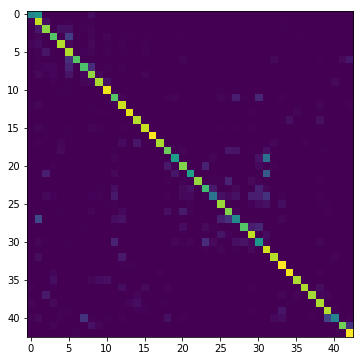

[[0.45 0.52 0.   ... 0.   0.   0.  ]
 [0.02 0.9  0.04 ... 0.   0.   0.  ]
 [0.   0.06 0.82 ... 0.   0.   0.  ]
 ...
 [0.01 0.02 0.   ... 0.44 0.   0.01]
 [0.   0.   0.   ... 0.   0.78 0.13]
 [0.   0.   0.   ... 0.   0.   0.99]]


In [23]:
M, acc = Confusion(test_data, test_labels, cnnClassifier)
print("Acc: ", acc)
VisualizeConfusion(M)

In [28]:
def test_img(f, classifier):
  img = cv2.imread(f, 0)
  img = cv2.resize(img, img_shape)
  
  #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  #img = cv2.filter2D(img, -1, kernel)
  
  #img = cv2.bilateralFilter(img, 5, 25, 25)
  
  imgs = []
  imgs.append(img)
  imgs = np.array(imgs)
  prediction = classifier(imgs)
  return prediction

count = 0
for i in range(23):
  #if i % 5 != 0:
  pred = test_img("screen/%d.png" % (i), cnnClassifier)

  if pred[0] == 14:
    print(i, pred)
    count += 1
    
print(count)

#for i in range(10):
#  for j in range(10):
#    print(test_img("GTSRB/train/%d/%05d_%05d.ppm" % (14, i, j), cnnClassifier))

5 [14]
6 [14]
7 [14]
8 [14]
10 [14]
14 [14]
15 [14]
16 [14]
17 [14]
21 [14]
22 [14]
11
